### Conexión a la base de datos

In [2]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Dask dependencias
import dask
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
import dask.bag as db
import time
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
import numpy as np
import json
import geopandas as gpd
from fuzzywuzzy import fuzz
import re

def start_dask_client():
    cliente = Client("tcp://scheduler:8786")
    cliente 
    

def leer_data():
    print("----> leyendo datos...")
    remote_path = './data.csv'
    # Lee el archivo CSV utilizando Dask y el cliente conectado
    df = dd.read_csv(remote_path, blocksize="20MB", encoding='latin-1', low_memory=False, dtype={'Fecha_muerte': 'object', 'Pais_viajo_1_nom': 'object', 'Pais_viajo_1_cod': 'object', 'per_etn_': 'float64'})
    print("----> datos leídos...")
    return df
    

def computed_data(df):
    print("----> computando datos...")
    full_data_computed = df.compute()
    print(full_data_computed.head(5))
    return full_data_computed

def contar_na(full_data):
    print(full_data.isna().sum())
    
def eliminar_na(full_data):
    full_data.dropna()
    full_data = full_data.drop(columns=['Caso', 'Fecha Not', 'Departamento', 'Ciudad_municipio', 'Fecha_inicio_sintomas', 'Fecha_diagnostico', 'Fecha_muerte', 'Pais_viajo_1_cod', 'Pais_viajo_1_nom', 'Fecha_recuperado', 'nom_grupo_', 'fecha_hoy_casos'])
    print(full_data)

def obtener_departamentos(full_data_computed):
    ruta_archivo = './colombia.geo.json'
    # Lee el archivo GeoJSON utilizando geopandas
    departamentos = gpd.read_file(ruta_archivo)
    return departamentos
    
def main():
    print("--------------------> LECTURA DE BASE DE DATOS")
    print("----> iniciando cliente de dask")
    # start_dask_client()
    # print("--------------------> PRE-PROCESAMIENTO DE LOS DATOS")
    # print("----> obtener_categoricos")
    # categoricos_data = obtener_categoricos(full_data)
    # print("----> visualizar_curva_inercias")
    # visualizar_curva_inercias(full_data.computed, categoricos_data)
    # print("----> imprimir_clusters")
    # imprimir_clusters(categoricos_data)


if __name__ == '__main__':
    start_time = time.time()
    print("----> Starting process ...")
    main()
    print("--- %s seconds ---" % (time.time() - start_time))
    print("----> Ending process")
    

----> Starting process ...
--------------------> LECTURA DE BASE DE DATOS
----> iniciando cliente de dask
--- 6.914138793945312e-05 seconds ---
----> Ending process


#### Lectura de la tabla "COVID"

In [3]:
print("----> leer_data")
full_data = leer_data()
full_data_computed = computed_data(full_data)

----> leer_data
----> leyendo datos...
----> datos leídos...
----> computando datos...
      Caso            Fecha Not  Departamento Departamento_nom   
0  2265685  2021-03-02 00:00:00            11           BOGOTA  \
1  2265686  2021-03-02 00:00:00            11           BOGOTA   
2  2265687  2021-03-02 00:00:00            11           BOGOTA   
3  2265688  2021-03-02 00:00:00            11           BOGOTA   
4  2265689  2021-03-02 00:00:00            11           BOGOTA   

   Ciudad_municipio Ciudad_municipio_nom  Edad  unidad_medida Sexo   
0             11001               BOGOTA    49              1    M  \
1             11001               BOGOTA    49              1    M   
2             11001               BOGOTA    51              1    F   
3             11001               BOGOTA    51              1    F   
4             11001               BOGOTA    51              1    F   

  Fuente_tipo_contagio  ...    Fecha_diagnostico Fecha_muerte   
0           En estudio  ...  2

##### Preprocesamiento de los datos

In [3]:
print("----> contar nulos o na")
contar_na(full_data_computed)

----> contar nulos o na
Caso                           0
Fecha Not                      0
Departamento                   0
Departamento_nom               0
Ciudad_municipio               0
Ciudad_municipio_nom           0
Edad                           0
unidad_medida                  0
Sexo                           0
Fuente_tipo_contagio           0
Ubicacion                  24096
Estado                     24096
Fecha_inicio_sintomas     622894
Fecha_diagnostico           2755
Fecha_muerte             5743063
Pais_viajo_1_cod         5898214
Pais_viajo_1_nom         5898215
Fecha_recuperado          223466
Recuperado                 20009
Tipo_recuperacion         223466
per_etn_                   85255
nom_grupo_               5823329
fecha_hoy_casos                0
dtype: int64


In [4]:
print("----> eliminar na y columnas inutiles para el análisis")
eliminar_na(full_data_computed)

----> eliminar na y columnas inutiles para el análisis
      Departamento_nom Ciudad_municipio_nom  Edad  unidad_medida Sexo   
0               BOGOTA               BOGOTA    49              1    M  \
1               BOGOTA               BOGOTA    49              1    M   
2               BOGOTA               BOGOTA    51              1    F   
3               BOGOTA               BOGOTA    51              1    F   
4               BOGOTA               BOGOTA    51              1    F   
...                ...                  ...   ...            ...  ...   
96541        CARTAGENA            CARTAGENA    35              1    F   
96542        CARTAGENA            CARTAGENA    32              1    M   
96543        CARTAGENA            CARTAGENA    15              1    F   
96544        CARTAGENA            CARTAGENA    29              1    M   
96545         AMAZONAS              LETICIA    85              1    F   

      Fuente_tipo_contagio Ubicacion Estado  Recuperado Tipo_recuper

Se eliminan aquellas columnas que no se considera aportan información relevante para el análisis deseado

In [5]:
full_data.dropna()
full_data = full_data.drop(columns=['Caso', 'Fecha Not', 'Departamento', 'Ciudad_municipio', 'Fecha_inicio_sintomas', 'Fecha_diagnostico', 'Fecha_muerte', 'Pais_viajo_1_cod', 'Pais_viajo_1_nom', 'Fecha_recuperado', 'nom_grupo_', 'fecha_hoy_casos'])

Transformación de los datos por columna, para ello se desea conocer los valores únicos que existen en cada columna para normalizarlos

In [5]:
full_data_computed["Sexo"].unique()

array(['M', 'F', 'm', 'f', 'M ', 'F  ', 'F '], dtype=object)

In [6]:
full_data_computed["Fuente_tipo_contagio"].unique()

array(['En estudio', 'Relacionado', 'Comunitaria', 'Relacionado ',
       'Importado', 'Comunitaria ', 'En estudio ', 'Importado ',
       'En estudio  '], dtype=object)

In [7]:
full_data_computed["Ubicacion"].unique()

array(['Casa', 'Fallecido', nan, 'Casa ', 'casa', 'Casa                ',
       'Casa                                                                                                                                                                                                    ',
       'Fallecido ', 'CASA', 'Casa        ', 'Hospital', 'Hospital UCI',
       'Hospital '], dtype=object)

In [8]:
full_data_computed["Estado"].unique()

array(['Leve', 'Fallecido', nan, 'Leve ', 'leve', 'Leve                ',
       'Leve                                                                                                                                                                                                    ',
       'Fallecido ', 'leve ', 'Leve   ', 'LEVE', 'Leve        ',
       'Moderado', 'Grave'], dtype=object)

In [9]:
full_data_computed["Recuperado"].unique()

array(['Recuperado', 'Fallecido', nan, 'Fallecido ', 'Recuperado ',
       'fallecido', 'Activo'], dtype=object)

In [10]:
full_data_computed["Tipo_recuperacion"].unique()

array(['Tiempo', 'PCR', nan, 'PCR ', 'Tiempo '], dtype=object)

full_data_computed en el entorno de python geopandas

In [9]:
print("----> obtener_departamentos")
departamentos = obtener_departamentos(full_data_computed)

----> obtener_departamentos


Reemplazar los nombres en la base de datos para que coincidan con el archivo .geojeson

In [ ]:
print("----> limpiando data...")
full_data_computed['Departamento_nom'] = full_data_computed['Departamento_nom'].replace('BOGOTA', 'SANTAFE DE BOGOTA D.C')
full_data_computed['Departamento_nom'] = full_data_computed['Departamento_nom'].replace('BARRANQUILLA', 'ATLANTICO')
full_data_computed['Departamento_nom'] = full_data_computed['Departamento_nom'].replace('VALLE', 'VALLE DEL CAUCA')
full_data_computed['Departamento_nom'] = full_data_computed['Departamento_nom'].replace('STA MARTA D.E.', 'MAGDALENA')
full_data_computed['Departamento_nom'] = full_data_computed['Departamento_nom'].replace('CARTAGENA', 'BOLIVAR')
full_data_computed['Departamento_nom'] = full_data_computed['Departamento_nom'].replace('NORTE SANTANDER', 'NORTE DE SANTANDER')
full_data_computed['Departamento_nom'] = full_data_computed['Departamento_nom'].replace('SAN ANDRES', 'ARCHIPIELAGO DE SAN ANDRES PROVIDENCIA Y SANTA CATALINA')

# Función para encontrar la mejor coincidencia aproximada
def encontrar_coincidencia(valor, opciones):
    mejor_puntuacion = -1
    mejor_opcion = None

    # Verificar si el valor es "en estudio" sin eliminar espacios en blanco
    if valor.lower() == 'en estudio':
        return 'en estudio'

    valor = re.sub(' +', ' ', valor.strip())  # Eliminar espacios en blanco adicionales

    for opcion in opciones:
        puntuacion = fuzz.ratio(valor, opcion)
        if puntuacion > mejor_puntuacion:
            mejor_puntuacion = puntuacion
            mejor_opcion = opcion

    return mejor_opcion


def aplicar_transformacion(columna, opciones):
    columna = columna.astype(str)

    # Convertir a minúsculas
    columna = columna.str.lower()

    # Eliminar caracteres especiales y puntuación
    columna = columna.str.replace('[^\w\s]', '', regex=True)

    # Reemplazar "N/A" con "Desconocido"
    columna = columna.replace('n/a', 'desconocido')

    # Reemplazar "" con "Desconocido"
    columna = columna.replace('', 'desconocido')

    # Reemplazar valores con la mejor coincidencia aproximada
    columna = columna.apply(lambda x: encontrar_coincidencia(x, opciones))
    return columna

def apply_transformations(df):
    opciones_por_columna = {
        'Sexo': ['f', 'm'],
        'Fuente_tipo_contagio': ['comunitaria', 'relacionado', 'en estudio', 'importado'],
        'Ubicacion': ['casa', 'fallecido', 'hospital'], 
        'Estado': ['leve', 'moderado', 'grave', 'fallecido'],
        'Recuperado': ['recuperado', 'fallecido', 'activo'],
        'Tipo_recuperacion': ['tiempo', 'pcr']
    }

    for columna, opciones in opciones_por_columna.items():
        df[columna] = aplicar_transformacion(df[columna], opciones)

    return df

# Aplicar las transformaciones utilizando map_partitions
full_data = full_data.map_partitions(apply_transformations)

full_data_computed = full_data.compute()
# Imprimir el resultado
print(full_data_computed)

#### Visualización inicial de los datos

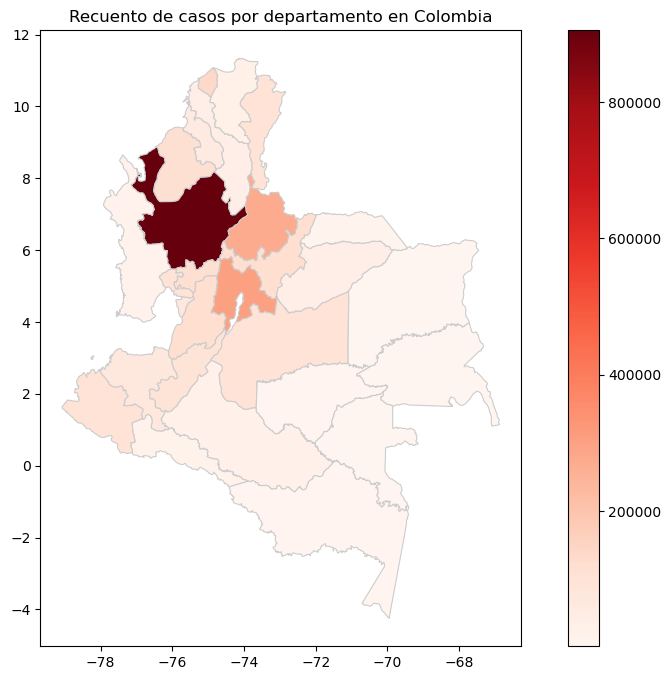

In [10]:
# Obtener el recuento de casos por departamento
recuento_departamentos = full_data_computed['Departamento_nom'].value_counts().reset_index()
recuento_departamentos.columns = ['Departamento_nom', 'Recuento_departamento']

# Combinar los datos geoespaciales de los departamentos con el recuento de casos
mapa_departamentos = departamentos.merge(recuento_departamentos, left_on='NOMBRE_DPT', right_on='Departamento_nom')

# Generar la visualización del mapa de casos por departamento
fig, ax = plt.subplots(figsize=(12, 8))
mapa_departamentos.plot(ax=ax, column='Recuento_departamento', cmap='Reds', linewidth=0.8, edgecolor='0.8', legend=True)
ax.set_title('Recuento de casos por departamento en Colombia')
plt.show()

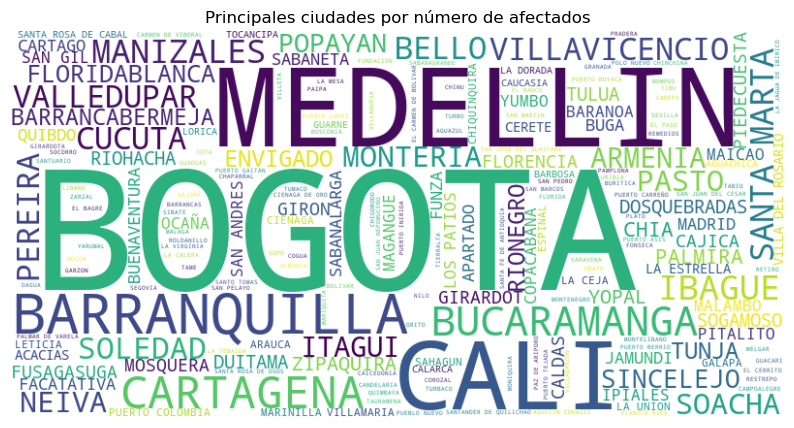

In [11]:
from wordcloud import WordCloud

# Especificar el nombre de la columna que contiene las palabras
columna_palabras = 'Ciudad_municipio_nom'

# Obtener el recuento de palabras y convertirlo a un diccionario de frecuencias
recuento_palabras = full_data_computed[columna_palabras].value_counts().to_dict()

# Crear el objeto WordCloud con las palabras y sus frecuencias
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(recuento_palabras)

# Configurar el tamaño de las palabras en la nube de palabras
wordcloud.recolor(random_state=42)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Principales ciudades por número de afectados')
plt.show()

#### Análisis de los datos

Llamado de librerias a usar

In [6]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
import numpy as np

In [7]:
sample_for_kmeans = full_data_computed.sample(frac=0.0001)
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
categoricos_data = encoder.fit_transform(sample_for_kmeans)
print(categoricos_data)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
# Combinación de atributos categóricos y numéricos
combined_features = np.concatenate((sample_for_kmeans, categoricos_data), axis=1)
print(combined_features)

[[987196 '2020-10-19 00:00:00' 50 ... 0.0 0.0 0.0]
 [1398286 '2020-12-05 00:00:00' 11 ... 0.0 0.0 0.0]
 [5523028 '2022-01-12 00:00:00' 23 ... 0.0 0.0 0.0]
 ...
 [5862781 '2022-01-29 00:00:00' 11 ... 0.0 1.0 0.0]
 [397352 '2020-07-27 00:00:00' 5 ... 0.0 0.0 0.0]
 [3377752 '2021-05-26 00:00:00' 11 ... 0.0 0.0 0.0]]


In [11]:
# Calcular la inercia para diferentes valores de k en K-means,utilizo datos categoricos, datos numericos genera error.
inertias = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(categoricos_data)
    inertias.append(kmeans.inertia_)

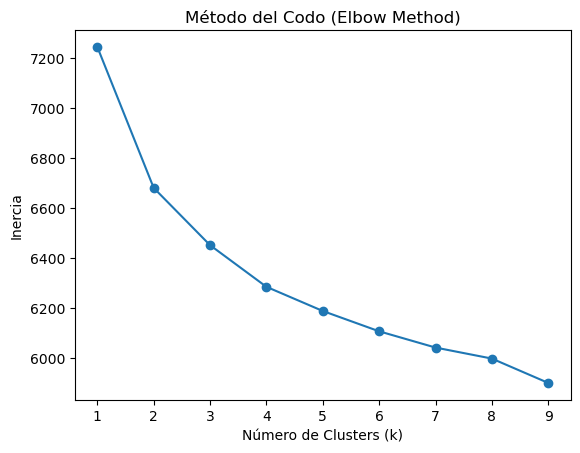

In [10]:
# Visualizar la curva de la inercia
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo (Elbow Method)')
plt.show()

In [12]:
# Obtener el número óptimo de clusters según el método del codo
optimal_k = 9  # Aquí se selecciona el 9 de acuerdo a grafica

In [13]:
# Aplicar K-modes a los atributos categóricos
kmodes = KModes(n_clusters=optimal_k, init='Huang', n_init=5, verbose=1)
clusters_kmodes = kmodes.fit_predict(categoricos_data)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 224, cost: 6565.0
Run 1, iteration: 2/100, moves: 42, cost: 6541.0
Run 1, iteration: 3/100, moves: 3, cost: 6541.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 205, cost: 6282.0
Run 2, iteration: 2/100, moves: 73, cost: 6260.0
Run 2, iteration: 3/100, moves: 0, cost: 6260.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 249, cost: 6449.0
Run 3, iteration: 2/100, moves: 26, cost: 6449.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 224, cost: 6615.0
Run 4, iteration: 2/100, moves: 49, cost: 6609.0
Run 4, iteration: 3/100, moves: 3, cost: 6609.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 221, cost: 6460.0
Run 5, ite

In [16]:
# Aplicar K-means a los atributos numéricos
kmeans = KMeans(n_clusters=optimal_k, n_init = 5, random_state=42)
clusters_kmeans = kmeans.fit_predict(categoricos_data)

In [17]:
# Combinar los resultados de K-modes y K-means
combined_clusters = np.column_stack((clusters_kmodes, clusters_kmeans))

In [18]:
# Imprimir los clusters resultantes
print("Clusters combinados:")
print(combined_clusters)

Clusters combinados:
[[8 7]
 [4 0]
 [0 6]
 ...
 [5 1]
 [8 5]
 [4 0]]


Según el tipo de columna de la base de datos se distingue entre númerica y categórica

In [19]:
def get_column_type(df):
  labels=list(df.columns)
  A=[]
  B=[]

  for i in range(len(df.columns)):
    if np.dtype(df[labels[i]]) != 'object':
      A.append(labels[i])
    else:
      B.append(labels[i])

  return A,B

In [23]:
# Aplicar K-means a los atributos numéricos
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
numeric_values = get_column_type(sample_for_kmeans)
print(numeric_values)
clusters_kmeans = kmeans.fit_predict()

(['Caso', 'Departamento', 'Ciudad_municipio', 'Edad', 'unidad_medida', 'per_etn_'], ['Fecha Not', 'Departamento_nom', 'Ciudad_municipio_nom', 'Sexo', 'Fuente_tipo_contagio', 'Ubicacion', 'Estado', 'Fecha_inicio_sintomas', 'Fecha_diagnostico', 'Fecha_muerte', 'Pais_viajo_1_cod', 'Pais_viajo_1_nom', 'Fecha_recuperado', 'Recuperado', 'Tipo_recuperacion', 'nom_grupo_', 'fecha_hoy_casos'])


TypeError: _BaseKMeans.fit_predict() missing 1 required positional argument: 'X'

Se generarán gráficos del comportamiento de la variable 'y', de las variables 'x' y del comportamiento de la variable 'y' en función de las variables 'x', estos gráficos serán diagramas de barras si las variables son categóricas e histogramas si son númericas.

In [24]:
def plot_y(df,label):
  A,B = get_column_type(df)
  if label in A:
    plt.hist(x=df[label])
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


  else:
    df.groupby(label).agg(variable=(label,"count")).plot(kind="bar")

In [25]:
from math import ceil
def plot_x(df,label):
  A,B= get_column_type(df)
  global fig,ax

  if label in A:
    B1=B.copy()
    A1=A.copy()
    A1.remove(label)
  else:
    A1=A.copy()
    B1=B.copy()
    B1.remove(label)

  #Graficar todas las x numericas   
  if not A1:
      print("")
  else:  
    n=ceil(len(A1)/2)
    print(n)
    fig, ax= plt.subplots(n,2, figsize=(10,12))
    for i,a in zip(A1,ax.ravel()): 
      #a.set_title(i)
      sns.histplot(x=i,data=df, ax=a)
      plt.tight_layout()
        
  #Graficar todas las x categoricas
  if not B1:
    print("")
  else:   
     n=ceil((len(B1))/2)
     fig, ax= plt.subplots(n,2, figsize=(10,12))
     for i,a in zip(B1,ax.ravel()): 
      sns.countplot(x=i,data=df, ax=a)
      a.set_title(i)

  return fig, ax

In [ ]:
def plot_xy(df,label):
  global fig, ax
  A,B= get_column_type(df)
  y=df[label].values

  #cuando y es numérica
  if label in A:
    A1=A.copy()
    A1.remove(label)
    # x númerica a y númerica
    if not A1:
      print('')
    else:
      n=ceil(len(A1)/2)
      fig, ax= plt.subplots(n,2,figsize=(10,12))
      for i,a in zip(A1, ax.ravel()):
          sns.scatterplot(x=i,y=label,data=df,ax=a)
          plt.tight_layout()
    # x categórica a y númerica
    if not B:
      print('')
    else:
      n=ceil(len(B)/2)
      fig, ax= plt.subplots(n,2, figsize=(10,12))
      plt.tight_layout()   
      for i,a in zip(B, ax.ravel()):
        sns.swarmplot(x=i,y=label,data=df,ax=a)
        plt.tight_layout()

  # Cuando y es categórica
  else:
    B1=B.copy()
    B1.remove(label)
    # x númerica a y categórica
    if not A:
      print('')
    else:
      n=ceil(len(A)/2)
      fig, ax= plt.subplots(n,2,figsize=(10,12))
      for i,a in zip(A, ax.ravel()):
        sns.histplot(x=i,hue=label,data=df,ax=a)
        plt.tight_layout()
    # x categórica a y categórica
    if not B1:
      print('')
    else:
      n=ceil(len(B1)/2)
      fig, ax= plt.subplots(n,2, figsize=(10,12))
      plt.tight_layout()   
      for i,a in zip(B1, ax.ravel()):
        sns.countplot(x=i,data=df,hue=label,ax=a)
    
  return fig, ax

In [26]:
def univariate_analysis(df,label):
  plot_y(df,label)
  plot_x(df,label)
  plot_xy(df,label)

3


ValueError: cannot reindex on an axis with duplicate labels

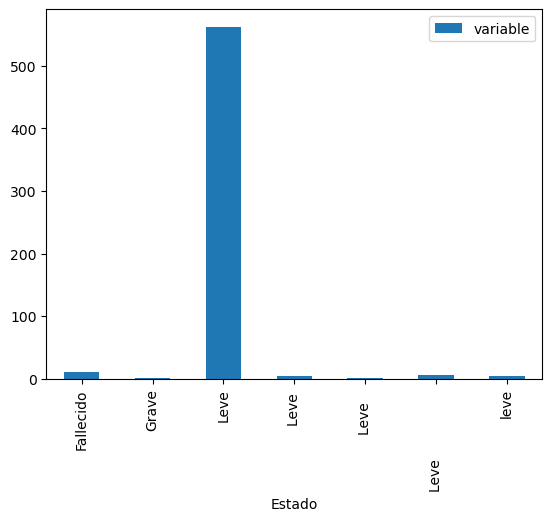

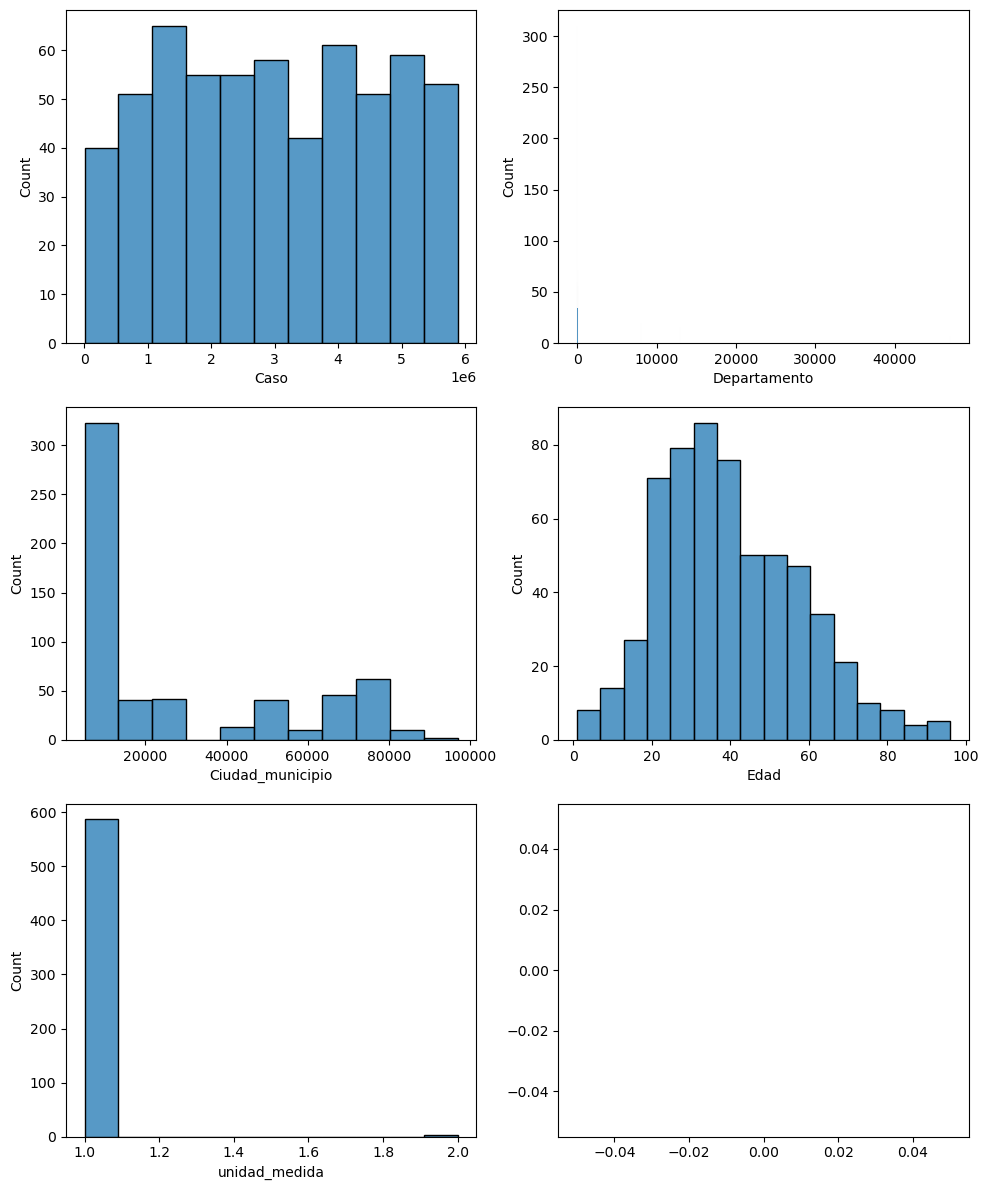

In [35]:
univariate_analysis(sample_for_kmeans, "Estado")

Ahora, se desea hacer un análisis bivariado, se toman dos 'x' y se analiza su comportamiento respecto a la 'y'

In [29]:
import itertools as it

In [36]:
def b_num(df,label):
  A,B= get_column_type(df)
  print(A)
  print(B)
  global fig,ax

  if label in A:
    A1=A.copy()
    A1.remove(label)
  else:
    A1=A
    
    #Graficar todas combinaciones de las x numericas   
  if not A1:
        print("")
  else:
      comb=list(it.combinations(A1,2))
      n=ceil(len(comb)/2)
     
      fig, axs= plt.subplots(n,2, figsize=(10,12))
      plt.tight_layout()
      for (c1,c2),ax in zip(comb,axs.ravel()): 
        ax.set_xlabel(c1)
        ax.set_ylabel(c2)
        #x numericas a y numerica
        if label in A:  
          for i in range(len(comb)):
            ax.scatter(df[c1],df[c2],cmap='Greens')
            

        #x numericas a y categorica
        else:
          for i,j in df.groupby(label):
            ax.scatter(j[c1],j[c2],label=i,alpha=0.5)
            ax.legend()
            fig.tight_layout()

In [37]:
def b_cat(df,label):
    A,B= get_column_type(df)
    global fig,ax

    if label in A:
      B1=B
    else:
      B1=B.copy()
      B1.remove(label)

    #Graficar todas las combinaciones de las x categóricas
    if not B1:
      print("")
    else: 
      comb=list(it.combinations(B1,2))
      n=ceil(len(comb)/2)
      for (c1,c2) in comb: 
        sns.histplot(x=c1,y=c2,data=df)
        
        plt.show()

In [38]:
def mapa_calor(df,label):
  A,B= get_column_type(df)

  if label in A:
      B1=B.copy()
      A1=A.copy()
      A1.remove(label)
  else:
      A1=A.copy()
      B1=B.copy()
      B1.remove(label)
 
  if not A1:
    print("")
  else:
    datos=(df.drop(B,axis=1))
    corrmat=datos.corr()
    plt.subplots(figsize=(12.8,12.8))
    sns.heatmap(corrmat,annot=True, center=0, cmap='RdBu')
    plt.title('Correlación entre todas las variables numéricas')

In [39]:
def bivariate_analysis(df,label):
  A,B= get_column_type(df)
  if not A:
    print("")
  else:
    b_num(df,label)
    mapa_calor(df,label)
  if not B:
    print("")
  else:
    b_cat(df,label)

['Caso', 'Departamento', 'Ciudad_municipio', 'Edad', 'unidad_medida', 'per_etn_']
['Fecha Not', 'Departamento_nom', 'Ciudad_municipio_nom', 'Sexo', 'Fuente_tipo_contagio', 'Ubicacion', 'Estado', 'Fecha_inicio_sintomas', 'Fecha_diagnostico', 'Fecha_muerte', 'Pais_viajo_1_cod', 'Pais_viajo_1_nom', 'Fecha_recuperado', 'Recuperado', 'Tipo_recuperacion', 'nom_grupo_', 'fecha_hoy_casos']


/tmp/ipykernel_45467/2025099346.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()
/tmp/ipykernel_45467/2025099346.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()
/tmp/ipykernel_45467/2025099346.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()
/tmp/ipykernel_45467/2025099346.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()
/tmp/ipykernel_45467/2025099346.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()
/tmp/ipykernel_45467/2025099346.py:36: UserWarning: Tight layout not a

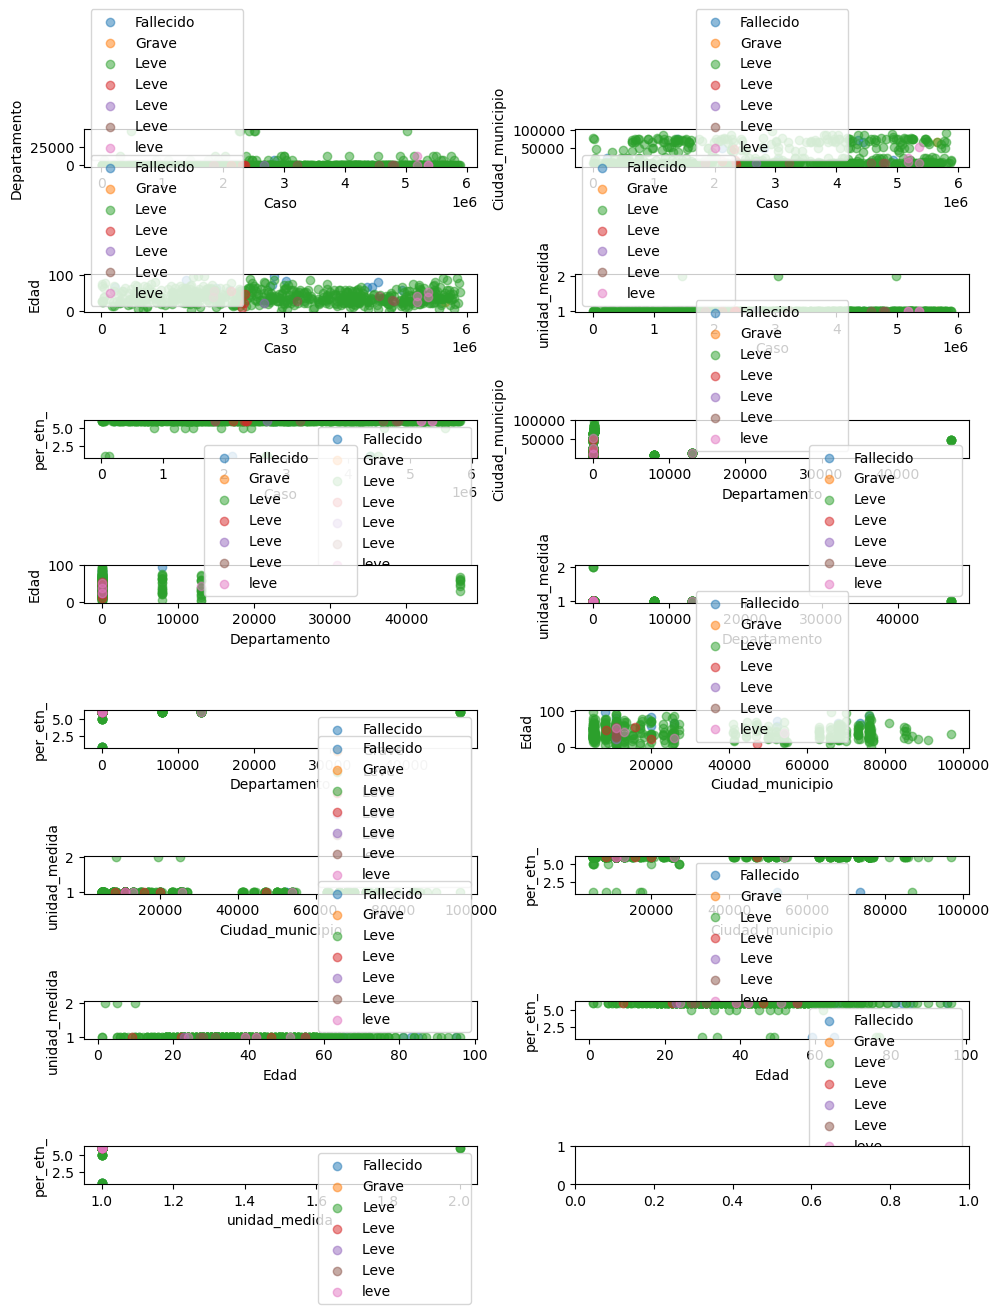

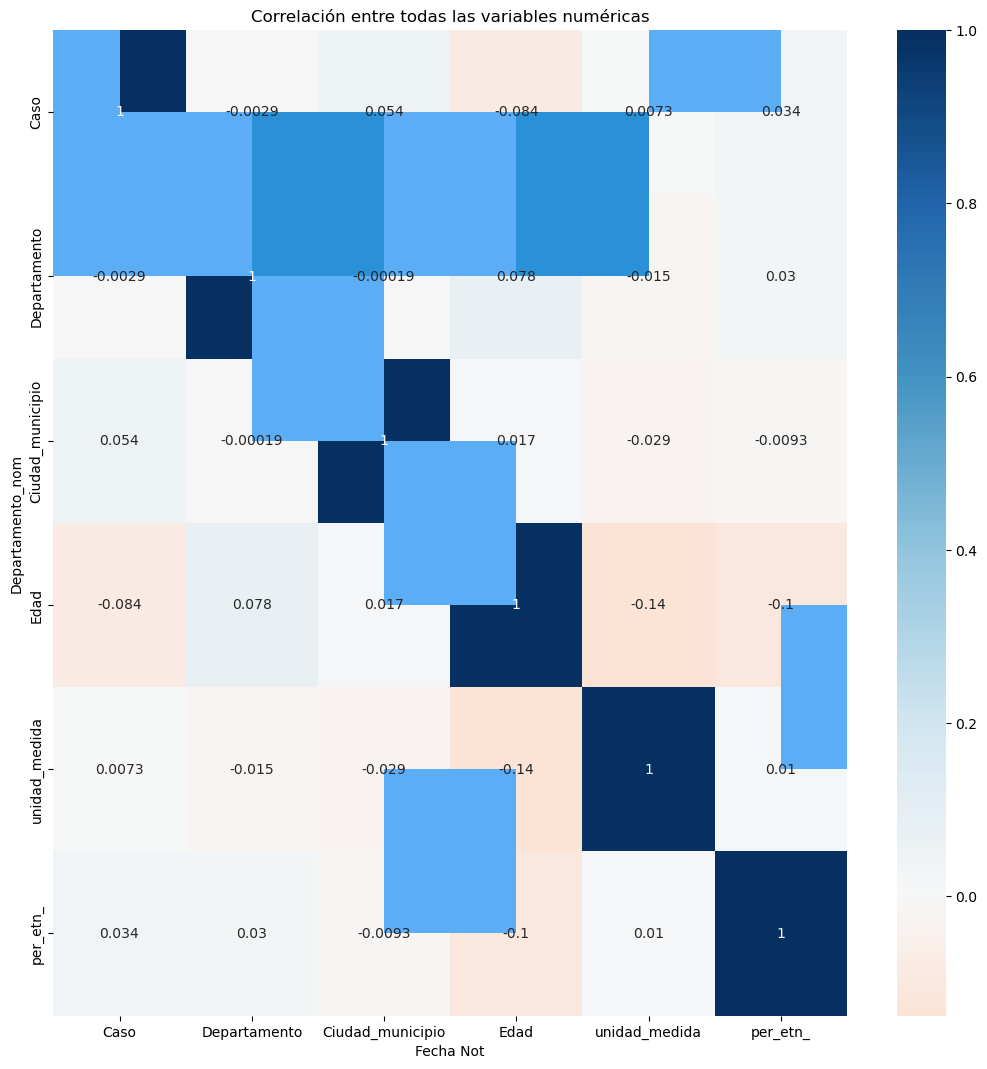

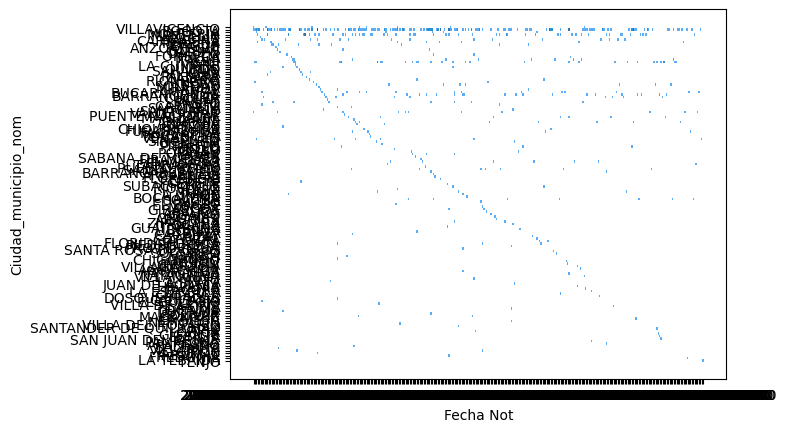

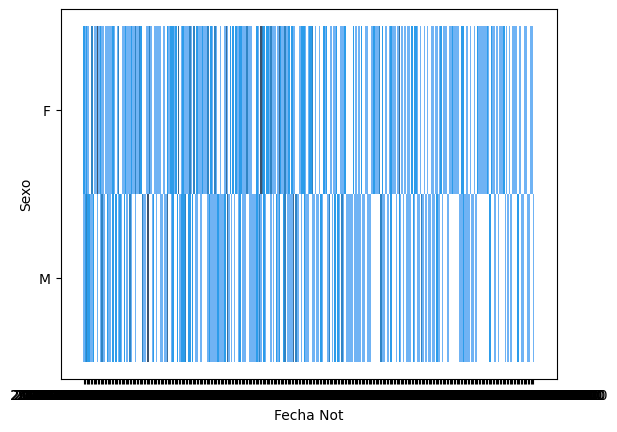

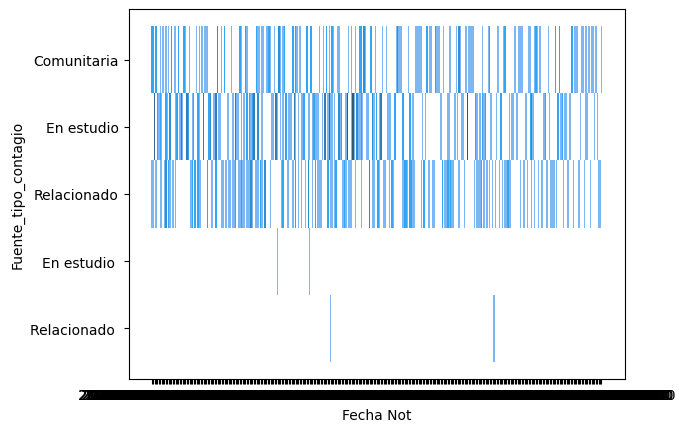

ValueError: cannot reindex on an axis with duplicate labels

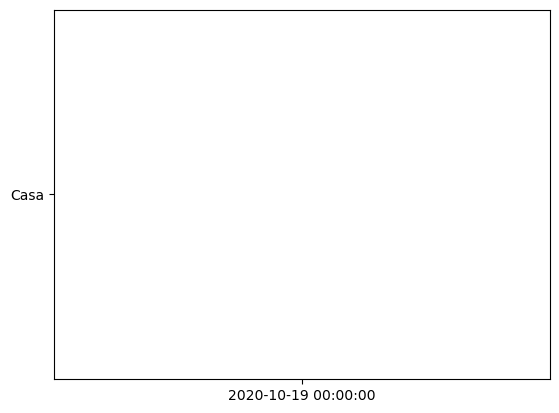

In [41]:
bivariate_analysis(sample_for_kmeans, "Estado")

#### Aplicación de Algoritmos de Clasificación

Primero se busca ver el comportamiento del algoritmo de clasificación a utilizar

In [42]:
def visualize_classifier_behavior(learner, X, y, ax = None):
    
    # To train
    
    learner.fit(X,y)
    
    #To identify the range of the columns
    
    ## Column 1
    
    r1 = max(X[:,0]) - min(X[:,0])
    
    ## Column 2
    
    r2 = max(X[:,1]) - min(X[:,1])
    
    # To create two lists 
    
    d1 = np.linspace(min(X[:,0])-0.1*r1, max(X[:,0])+0.1*r1, 100)
    
    d2 = np.linspace(min(X[:,1])-0.1*r2, max(X[:,1])+0.1*r2, 100)
    
    # To create a 100x100 matrix
    
    D1, D2 = np.meshgrid(d1,d2)

    # To predict

    Z = learner.predict(np.column_stack((D1.ravel(), D2.ravel())))
    Z = Z.reshape(D1.shape)
        
    
    # To replace the class names
    
    if ax is None:
        
        fig, ax = plt.subplots()
        
    ax.contourf(D1,D2,Z,alpha=0.5)
    ax.scatter(X[:,0], X[:,1], c=y, cmap='viridis')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title('Decision boundary')

In [43]:
# To call the classifiers

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [44]:
# To define the nicknames of the classifiers

knn = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression()
dt = DecisionTreeClassifier(max_depth=3)

In [45]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [51]:
convertir(sample_for_kmeans, "Estado")

['Caso', 'Departamento', 'Ciudad_municipio', 'Edad', 'unidad_medida', 'per_etn_']
['Fecha Not', 'Departamento_nom', 'Ciudad_municipio_nom', 'Sexo', 'Fuente_tipo_contagio', 'Ubicacion', 'Estado', 'Fecha_inicio_sintomas', 'Fecha_diagnostico', 'Fecha_muerte', 'Pais_viajo_1_cod', 'Pais_viajo_1_nom', 'Fecha_recuperado', 'Recuperado', 'Tipo_recuperacion', 'nom_grupo_', 'fecha_hoy_casos']


[('Caso', 'Departamento'),
 ('Caso', 'Ciudad_municipio'),
 ('Caso', 'Edad'),
 ('Caso', 'unidad_medida'),
 ('Caso', 'per_etn_'),
 ('Caso', 'Fecha Not'),
 ('Caso', 'Departamento_nom'),
 ('Caso', 'Ciudad_municipio_nom'),
 ('Caso', 'Sexo'),
 ('Caso', 'Fuente_tipo_contagio'),
 ('Caso', 'Ubicacion'),
 ('Caso', 'Estado'),
 ('Caso', 'Fecha_inicio_sintomas'),
 ('Caso', 'Fecha_diagnostico'),
 ('Caso', 'Fecha_muerte'),
 ('Caso', 'Pais_viajo_1_cod'),
 ('Caso', 'Pais_viajo_1_nom'),
 ('Caso', 'Fecha_recuperado'),
 ('Caso', 'Recuperado'),
 ('Caso', 'Tipo_recuperacion'),
 ('Caso', 'nom_grupo_'),
 ('Caso', 'fecha_hoy_casos'),
 ('Departamento', 'Ciudad_municipio'),
 ('Departamento', 'Edad'),
 ('Departamento', 'unidad_medida'),
 ('Departamento', 'per_etn_'),
 ('Departamento', 'Fecha Not'),
 ('Departamento', 'Departamento_nom'),
 ('Departamento', 'Ciudad_municipio_nom'),
 ('Departamento', 'Sexo'),
 ('Departamento', 'Fuente_tipo_contagio'),
 ('Departamento', 'Ubicacion'),
 ('Departamento', 'Estado'),
 ('De

In [52]:
def convertir(df,label):

  A,B= get_column_type(df)
  print(A)
  print(B)
  global fig,ax

  for i in B:

    df[i]=encoder.fit_transform(df[i])

  C = A+B

  comb=list(it.combinations(C,2))
  
  return comb

In [53]:
convertir(sample_for_kmeans, 'Estado')

['Caso', 'Fecha Not', 'Departamento', 'Departamento_nom', 'Ciudad_municipio', 'Ciudad_municipio_nom', 'Edad', 'unidad_medida', 'Sexo', 'Fuente_tipo_contagio', 'Ubicacion', 'Estado', 'Fecha_inicio_sintomas', 'Fecha_diagnostico', 'Fecha_muerte', 'Pais_viajo_1_cod', 'Pais_viajo_1_nom', 'Fecha_recuperado', 'Recuperado', 'Tipo_recuperacion', 'per_etn_', 'nom_grupo_', 'fecha_hoy_casos']
[]


[('Caso', 'Fecha Not'),
 ('Caso', 'Departamento'),
 ('Caso', 'Departamento_nom'),
 ('Caso', 'Ciudad_municipio'),
 ('Caso', 'Ciudad_municipio_nom'),
 ('Caso', 'Edad'),
 ('Caso', 'unidad_medida'),
 ('Caso', 'Sexo'),
 ('Caso', 'Fuente_tipo_contagio'),
 ('Caso', 'Ubicacion'),
 ('Caso', 'Estado'),
 ('Caso', 'Fecha_inicio_sintomas'),
 ('Caso', 'Fecha_diagnostico'),
 ('Caso', 'Fecha_muerte'),
 ('Caso', 'Pais_viajo_1_cod'),
 ('Caso', 'Pais_viajo_1_nom'),
 ('Caso', 'Fecha_recuperado'),
 ('Caso', 'Recuperado'),
 ('Caso', 'Tipo_recuperacion'),
 ('Caso', 'per_etn_'),
 ('Caso', 'nom_grupo_'),
 ('Caso', 'fecha_hoy_casos'),
 ('Fecha Not', 'Departamento'),
 ('Fecha Not', 'Departamento_nom'),
 ('Fecha Not', 'Ciudad_municipio'),
 ('Fecha Not', 'Ciudad_municipio_nom'),
 ('Fecha Not', 'Edad'),
 ('Fecha Not', 'unidad_medida'),
 ('Fecha Not', 'Sexo'),
 ('Fecha Not', 'Fuente_tipo_contagio'),
 ('Fecha Not', 'Ubicacion'),
 ('Fecha Not', 'Estado'),
 ('Fecha Not', 'Fecha_inicio_sintomas'),
 ('Fecha Not', 'Fecha_

In [55]:
X = sample_for_kmeans[["Edad", "Fuente_tipo_contagio"]].values
y = sample_for_kmeans[["Estado"]].values

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


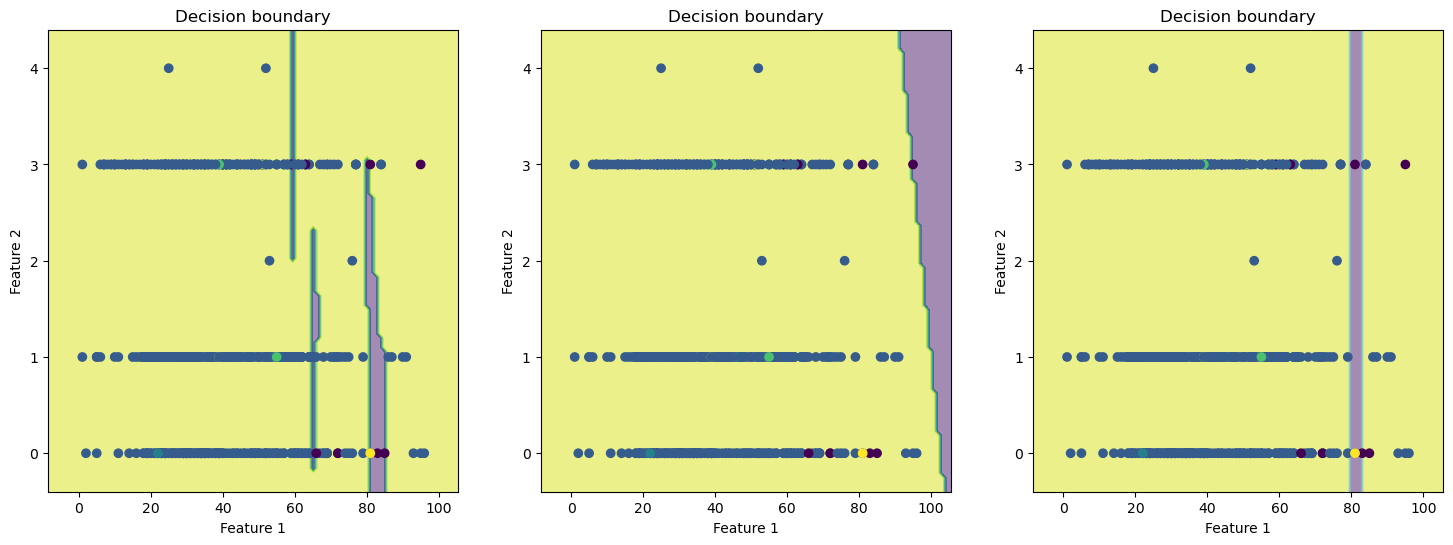

In [56]:
fig, axes = plt.subplots(1,3,figsize = (18,6))

visualize_classifier_behavior(knn, X, y.ravel(), ax=axes[0])

visualize_classifier_behavior(lr, X, y.ravel(), ax=axes[1])

visualize_classifier_behavior(dt, X, y.ravel(), ax=axes[2])

In [58]:
X = sample_for_kmeans[['Fuente_tipo_contagio', 'Recuperado']].values
y = sample_for_kmeans[["Estado"]].values

In [ ]:
fig, axes = plt.subplots(1,3,figsize = (18,6))

visualize_classifier_behavior(knn, X, y.ravel(), ax=axes[0])

visualize_classifier_behavior(lr, X, y.ravel(), ax=axes[1])

visualize_classifier_behavior(dt, X, y.ravel(), ax=axes[2])

In [59]:
X = sample_for_kmeans[['Ubicacion', 'Tipo_recuperacion']].values
y = sample_for_kmeans[["Estado"]].values

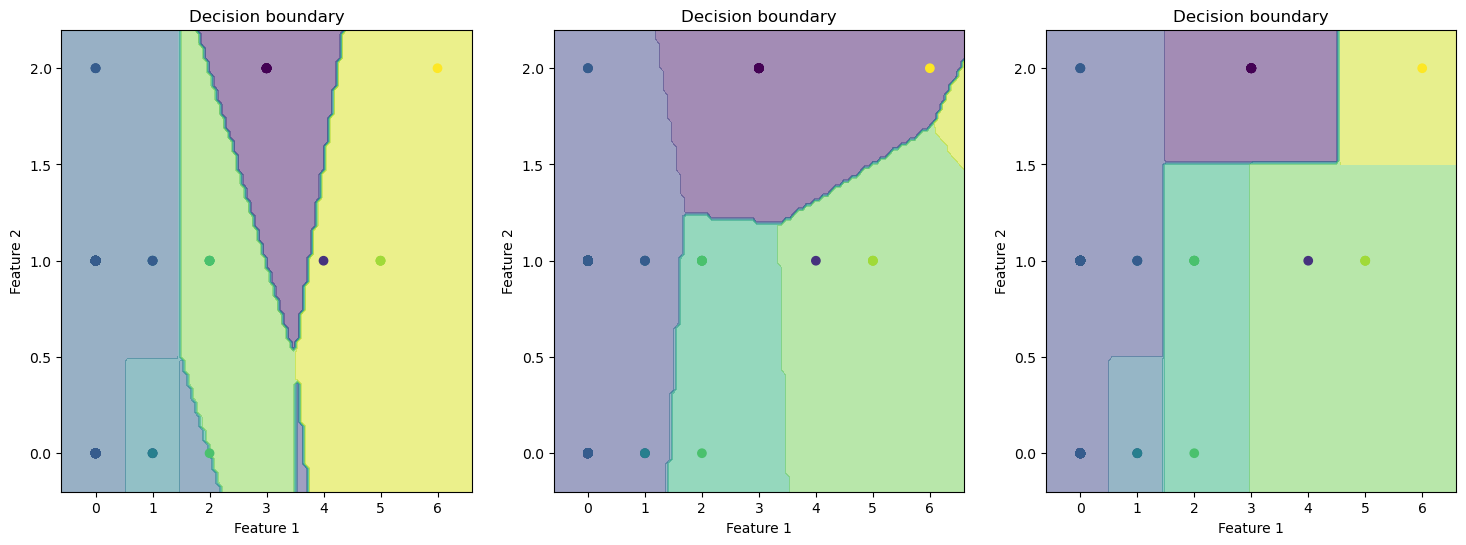

In [60]:
fig, axes = plt.subplots(1,3,figsize = (18,6))

visualize_classifier_behavior(knn, X, y.ravel(), ax=axes[0])

visualize_classifier_behavior(lr, X, y.ravel(), ax=axes[1])

visualize_classifier_behavior(dt, X, y.ravel(), ax=axes[2])